## Apress - Industrialized Machine Learning Examples

Andreas Francois Vermeulen
2019

### This is an example add-on to a book and needs to be accepted as part of that copyright.

## Chapter-008-005-Compare-clustering-01

In [1]:
import matplotlib
matplotlib.use('TkAgg')
%matplotlib inline

import time
import warnings

import numpy as np
import matplotlib.pyplot as plt

from sklearn import cluster, datasets, mixture
from sklearn.neighbors import kneighbors_graph
from sklearn.preprocessing import StandardScaler
from itertools import cycle, islice

In [2]:
np.random.seed(1968)

## Generate datasets

In [3]:
n_samples = 1000

In [4]:
noisy_circles1 = datasets.make_circles(n_samples=n_samples, factor=0.5, noise=0.05)
noisy_circles2 = datasets.make_circles(n_samples=n_samples, factor=0.15, noise=0.25)

noisy_moons1 = datasets.make_moons(n_samples=n_samples, noise=.05)
noisy_moons2 = datasets.make_moons(n_samples=n_samples, noise=.15)

blobs1 = datasets.make_blobs(n_samples=n_samples, random_state=50)
blobs2 = datasets.make_blobs(n_samples=n_samples, random_state=1968)

no_structure1 = np.random.rand(n_samples, 2), None
no_structure2 = np.random.rand(n_samples, 4), None

# Anisotropicly distributed data
random_state = 1705
X, y = datasets.make_blobs(n_samples=n_samples, random_state=random_state)

transformation1 = [[0.6, -0.6], [-0.4, 0.8]]
X_aniso1 = np.dot(X, transformation1)
aniso1 = (X_aniso1, y)

transformation2 = [[0.8, -0.8], [-0.2, 0.8]]
X_aniso2 = np.dot(X, transformation2)
aniso2 = (X_aniso2, y)

# blobs with varied variances
varied1 = datasets.make_blobs(n_samples=n_samples,
                             cluster_std=[1.0, 2.5, 0.5],
                             random_state=random_state)
varied2 = datasets.make_blobs(n_samples=n_samples,
                             cluster_std=[2.0, 1.5, 0.5],
                             random_state=random_state)

## Set up cluster parameters

In [5]:
plot_num = 1

default_base = {'quantile': 0.3,
                'eps': 0.4,
                'damping': 0.6,
                'preference': -200,
                'n_neighbors': 5,
                'n_clusters': 3}

datasets = [
    (aniso1, {'eps': 0.15, 'n_neighbors': 2}),
    (aniso1, {'eps': 0.55, 'n_neighbors': 4}),
    (aniso2, {'eps': 0.05, 'n_neighbors': 6}),
    (blobs1, {}),
    (blobs2, {}),
    (noisy_circles1, {'damping': 0.8, 'preference': -240, 'quantile': 0.2, 'n_clusters': 2}),
    (noisy_circles2, {'damping': 0.7, 'preference': -140, 'quantile': 0.8, 'n_clusters': 4}),
    (noisy_moons1, {'damping': 0.6, 'preference': -220, 'n_clusters': 2}),
    (noisy_moons2, {'damping': 0.75, 'preference': -100, 'n_clusters': 4}),
    (no_structure1, {}),
    (no_structure2, {}),
    (varied1, {'eps': 0.18, 'n_neighbors': 2}),
    (varied2, {'eps': 0.38, 'n_neighbors': 6}),
    (varied2, {'eps': 0.88, 'n_neighbors': 8})
]

C:\Users\AndreVermeulen\.conda\envs\andre\lib\site-packages\sklearn\cluster\affinity_propagation_.py:224: ConvergenceWarning: Affinity propagation did not converge, this model will not have any cluster centers.
  "will not have any cluster centers.", ConvergenceWarning)


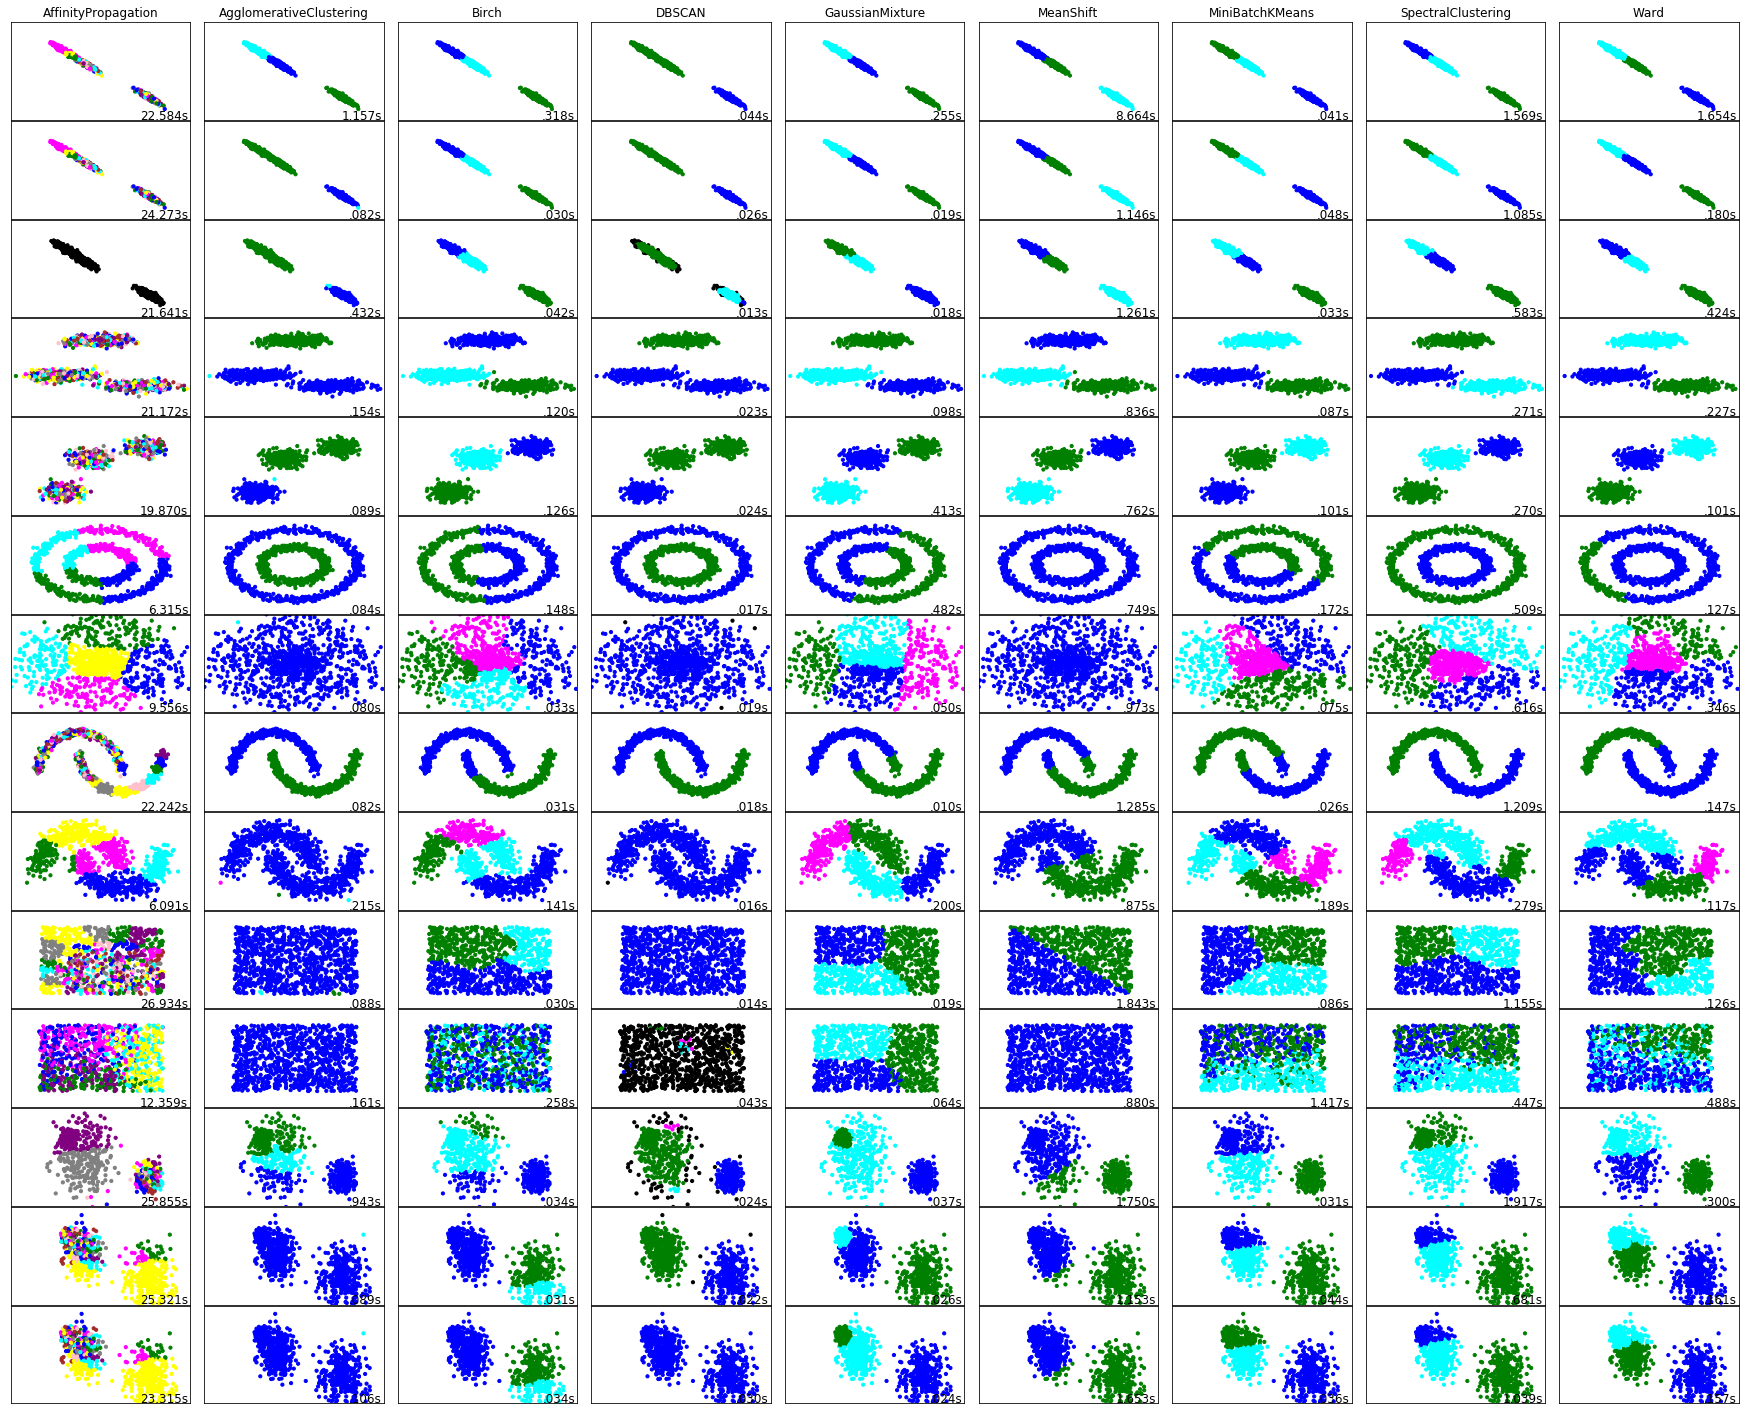

In [6]:
plt.figure(figsize=(25, 20))
plt.subplots_adjust(left=0.02, right=0.98, bottom=.001, top=0.96, wspace=.08, hspace=0.01)

for i_dataset, (dataset, algo_params) in enumerate(datasets):
    # update parameters with dataset-specific values
    params = default_base.copy()
    params.update(algo_params)

    X, y = dataset

    # normalize dataset for easier parameter selection
    X = StandardScaler().fit_transform(X)

    # estimate bandwidth for mean shift
    bandwidth = cluster.estimate_bandwidth(X, quantile=params['quantile'])

    # connectivity matrix for structured Ward
    connectivity = kneighbors_graph(
        X, n_neighbors=params['n_neighbors'], include_self=False)
    # make connectivity symmetric
    connectivity = 0.5 * (connectivity + connectivity.T)

    # ============
    # Create cluster objects
    # ============
    ms = cluster.MeanShift(bandwidth=bandwidth, bin_seeding=True, n_jobs=-1)
    two_means = cluster.MiniBatchKMeans(n_clusters=params['n_clusters'])
    ward = cluster.AgglomerativeClustering(
        n_clusters=params['n_clusters'], linkage='ward',
        connectivity=connectivity)
    spectral = cluster.SpectralClustering(
        n_clusters=params['n_clusters'], eigen_solver='arpack',
        affinity="nearest_neighbors")
    dbscan = cluster.DBSCAN(eps=params['eps'])
    affinity_propagation = cluster.AffinityPropagation(
        damping=params['damping'], preference=params['preference'])
    average_linkage = cluster.AgglomerativeClustering(
        linkage="average", affinity="cityblock",
        n_clusters=params['n_clusters'], connectivity=connectivity)
    birch = cluster.Birch(n_clusters=params['n_clusters'])
    gmm = mixture.GaussianMixture(
        n_components=params['n_clusters'], covariance_type='full')

    clustering_algorithms = (
        ('AffinityPropagation', affinity_propagation),
        ('AgglomerativeClustering', average_linkage),
        ('Birch', birch),
        ('DBSCAN', dbscan),
        ('GaussianMixture', gmm),
        ('MeanShift', ms),
        ('MiniBatchKMeans', two_means),
        ('SpectralClustering', spectral),
        ('Ward', ward)
    )

    for name, algorithm in clustering_algorithms:
        t0 = time.time()

        # catch warnings related to kneighbors_graph
        with warnings.catch_warnings():
            warnings.filterwarnings(
                "ignore",
                message="the number of connected components of the " +
                "connectivity matrix is [0-9]{1,2}" +
                " > 1. Completing it to avoid stopping the tree early.",
                category=UserWarning)
            warnings.filterwarnings(
                "ignore",
                message="Graph is not fully connected, spectral embedding" +
                " may not work as expected.",
                category=UserWarning)
            algorithm.fit(X)

        t1 = time.time()
        if hasattr(algorithm, 'labels_'):
            y_pred = algorithm.labels_.astype(np.int)
        else:
            y_pred = algorithm.predict(X)

        plt.subplot(len(datasets), len(clustering_algorithms), plot_num)
        if i_dataset == 0:
            plt.title(name, size=12)

        colors = np.array(list(islice(cycle(['blue', 'green', 'cyan', 'magenta', 'yellow', 
                                             'purple', 'brown', 'gray', 'pink']),
                                      int(max(y_pred) + 1))))
        # add black color for outliers (if any)
        colors = np.append(colors, ["black"])
        
        plt.scatter(X[:, 0], X[:, 1], s=10, color=colors[y_pred])

        plt.xlim(-2.5, 2.5)
        plt.ylim(-2.5, 2.5)
        plt.xticks(())
        plt.yticks(())
        plt.text(.99, .01, ('%0.3fs' % (t1 - t0)).lstrip('0'),
                 transform=plt.gca().transAxes, size=12,
                 horizontalalignment='right')
        plot_num += 1

plt.show()

## Done

In [7]:
import datetime
now = datetime.datetime.now()
print('Done!',str(now))

Done! 2019-10-19 21:28:30.615034
